# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scrnatools as rna
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
sc.set_figure_params(dpi=80, dpi_save=600, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.grid"] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

## Set up file paths

### demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Import data

In [7]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/IL13KO_TECs.h5ad")

# Differential Density

## Fezf2 KO

In [8]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="batch",
    groups=["WT", "IL13KO"],
    key_added="IL13_KO/WT_genotype_density",
    latent_rep="X_umap",
)

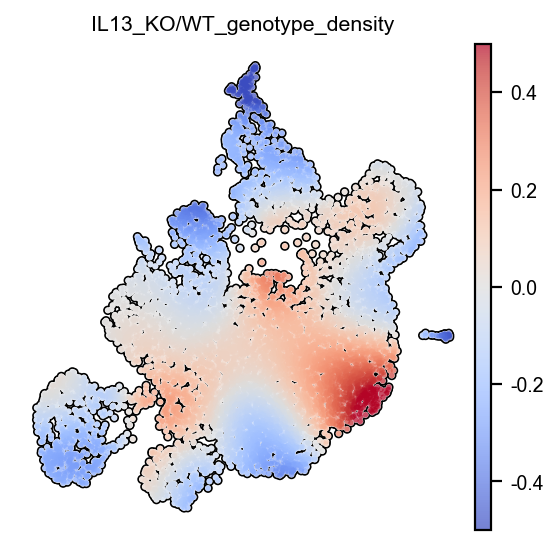

In [13]:
sc.settings.figdir = "../../analysis/paper_figures/1/"
sc.pl.umap(
    adata,
    color="IL13_KO/WT_genotype_density",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    # save="_1D_Fezf2_KO_density.pdf",
    add_outline=True,
    s=25
)

In [19]:
adata[adata.obs.batch == "WT"].obs.majority_voting.value_counts()

Aire-stage        1917
Immature MEC       430
Gut/Liver          429
Lung, basal        413
TA MEC             281
Neuroendocrine     232
Mcell              208
Tuft1              196
Tuft2              170
Skin, basal        143
adult cTEC          98
Ciliated            58
Goblet              47
Name: majority_voting, dtype: int64

In [20]:
adata[adata.obs.batch == "IL13KO"].obs.majority_voting.value_counts()

Aire-stage        2154
Gut/Liver          560
Immature MEC       352
Lung, basal        352
TA MEC             273
Neuroendocrine     170
Mcell              167
Tuft2              158
Skin, basal        152
Tuft1              144
adult cTEC          43
Ciliated            37
Goblet              37
Name: majority_voting, dtype: int64

# Cell type abundance

In [10]:
abundance_data = pd.DataFrame()
for genotype in adata.obs.batch.unique():
    genotype_data = adata[adata.obs.batch == genotype]
    cell_type_abundances = genotype_data.obs.majority_voting.value_counts()
    cell_type_abundances = cell_type_abundances/genotype_data.shape[0]*100
    cell_type_abundances = pd.DataFrame(cell_type_abundances)
    cell_type_abundances = cell_type_abundances.reset_index()
    cell_type_abundances.columns = ["cell_type", "abundance"]
    cell_type_abundances["genotype"] = genotype
    abundance_data = pd.concat([abundance_data, cell_type_abundances], ignore_index=True)

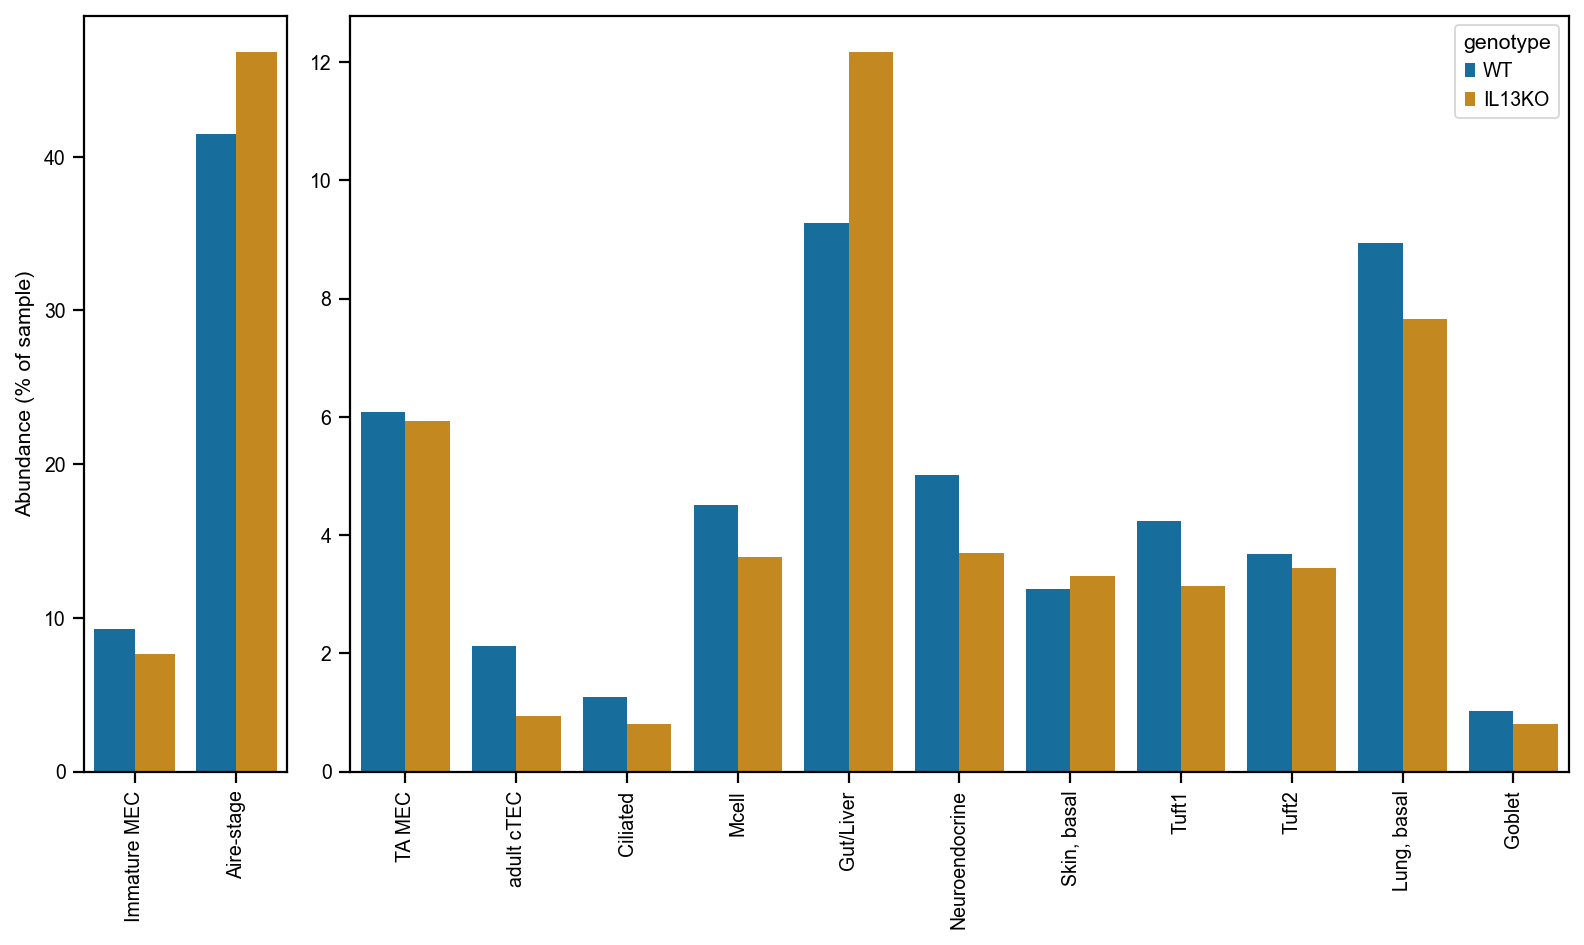

In [16]:
fig, axs = plt.subplots(1,2,figsize=(10,6), gridspec_kw={'width_ratios': [1, 6]})

sns.barplot(
    abundance_data[abundance_data.cell_type.isin(["Aire-stage", "Immature MEC"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[0],
    # errorbar=("pi", 100),
    errorbar=None,
    order = ["Immature MEC", "Aire-stage"],
    palette=cmap[0:2] + [cmap[4]],
)
axs[0].get_legend().remove()
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel("")
axs[0].set_ylabel("Abundance (% of sample)")
axs[0].grid(False)

sns.barplot(
    abundance_data[~abundance_data.cell_type.isin(["Aire-stage", "Immature MEC"])],
    x="cell_type",
    y="abundance",
    hue="genotype",
    ax=axs[1],
    # errorbar=("pi", 100),
    errorbar=None,
    order = [
        "TA MEC", "adult cTEC", "Ciliated", "Mcell", 
        "Gut/Liver", "Neuroendocrine", "Skin, basal",
        "Tuft1", "Tuft2", "Lung, basal", "Goblet",
    ],
    palette=cmap[0:2] + [cmap[4]],
)
axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].grid(False)

plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
# plt.savefig("../../analysis/paper_figures/1/1E_scRNAseq_cell_type_abundances.pdf")
plt.show()